# Introduction

A notebook that I use to familiarise myself with PyTorch.

The code below shows how to

- compute gradients in a computation graph with PyTorch
- let PyTorch learn how to add (or subtract) two numbers using a Perceptron

# Autograd

## Scalars don't have derivatives

In [1]:
import torch

In [2]:
!pip show torch

Name: torch
Version: 1.12.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/juebrauer/.local/share/virtualenvs/central-kQZYXD-3/lib/python3.8/site-packages
Requires: typing-extensions
Required-by: thop, torchvision


In [3]:
!pip install torch==

ERROR: Could not find a version that satisfies the requirement torch== (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==


In [4]:
x = torch.ones(1, requires_grad=True)

In [5]:
x

tensor([1.], requires_grad=True)

In [6]:
print(x)

tensor([1.], requires_grad=True)


In [7]:
type(x)

torch.Tensor

In [8]:
print(x.grad)

None


x is just a scalar that stores the value 1.0.  Therefore, it has no derivative.

## A function has a derivative

In [9]:
x = torch.ones(1, requires_grad=True)
y = 2*x

In [10]:
type(x)

torch.Tensor

In [11]:
type(y)

torch.Tensor

In [12]:
x

tensor([1.], requires_grad=True)

In [13]:
y

tensor([2.], grad_fn=<MulBackward0>)

In [14]:
print(x.grad)

None


The derivative of y with respect to x is not yet computed. First we have to call:

In [15]:
y.backward()

In [16]:
help(torch.Tensor.backward)

Help on function backward in module torch._tensor:

backward(self, gradient=None, retain_graph=None, create_graph=False, inputs=None)
    Computes the gradient of current tensor w.r.t. graph leaves.
    
    The graph is differentiated using the chain rule. If the tensor is
    non-scalar (i.e. its data has more than one element) and requires
    gradient, the function additionally requires specifying ``gradient``.
    It should be a tensor of matching type and location, that contains
    the gradient of the differentiated function w.r.t. ``self``.
    
    This function accumulates gradients in the leaves - you might need to zero
    ``.grad`` attributes or set them to ``None`` before calling it.
    See :ref:`Default gradient layouts<default-grad-layouts>`
    for details on the memory layout of accumulated gradients.
    
    .. note::
    
        If you run any forward ops, create ``gradient``, and/or call ``backward``
        in a user-specified CUDA stream context, see
        :

In [17]:
print(x.grad)

tensor([2.])


We see a 2, since $\frac{dy}{dx} = 2$

## Another example for automatic gradient computation

In [18]:
x = torch.ones(1, requires_grad=True)
y = 2*x
z = y*y*y

In [19]:
type(x)

torch.Tensor

In [20]:
type(y)

torch.Tensor

In [21]:
type(z)

torch.Tensor

In [22]:
x

tensor([1.], requires_grad=True)

In [23]:
x.item()

1.0

In [24]:
y

tensor([2.], grad_fn=<MulBackward0>)

In [25]:
z

tensor([8.], grad_fn=<MulBackward0>)

In [26]:
z.backward()

In [27]:
z.grad

/home/juebrauer/.local/share/virtualenvs/central-kQZYXD-3/lib/python3.8/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:482.)
  return self._grad


In [28]:
y.grad

In [29]:
x.grad

tensor([24.])

$\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx} = 3y^2 * 2 = 6(2x)^2 = 6*4x^2 = 24x^2$

# Machine learning

## Prepare a Perceptron

We build a Perceptron with 2 inputs, 5 hidden neurons, 1 output neuron

In [30]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super().__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)        
        
    def forward(self, input_vec):
        
        out1 = self.layer1(input_vec)
        out2 = self.layer2(out1)
        return out2        

In [31]:
p = Perceptron(2,5,1)

In [32]:
p

Perceptron(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [33]:
p.layer1.weight.shape

torch.Size([5, 2])

In [34]:
p.layer1.weight

Parameter containing:
tensor([[-0.0058, -0.0868],
        [-0.5234,  0.0344],
        [ 0.6240,  0.1887],
        [-0.4924, -0.2622],
        [-0.2386,  0.5131]], requires_grad=True)

In [35]:
p.layer1.bias

Parameter containing:
tensor([ 0.6559,  0.0313, -0.2060, -0.5471, -0.1566], requires_grad=True)

In [36]:
p.layer2.weight.shape

torch.Size([1, 5])

In [37]:
p.layer2.weight

Parameter containing:
tensor([[ 0.3013, -0.0798, -0.0337,  0.1695,  0.3993]], requires_grad=True)

In [38]:
p.layer2.bias

Parameter containing:
tensor([-0.2070], requires_grad=True)

## Feedforward with untrained Perceptron

In [39]:
input_vec = torch.tensor([1.0,3.0])

In [40]:
p(input_vec)

tensor([0.0556], grad_fn=<AddBackward0>)

In [41]:
p.forward(input_vec)

tensor([0.0556], grad_fn=<AddBackward0>)

## Train the Perceptron

In [42]:
p = Perceptron(2,5,1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(p.parameters(), lr=0.001)

In [43]:
type(loss_fn)

torch.nn.modules.loss.MSELoss

In [44]:
type(optimizer)

torch.optim.sgd.SGD

In [45]:
import numpy
x1 = numpy.random.rand()
x2 = numpy.random.rand()
x1,x2

(0.9446775790687395, 0.8358300286617169)

In [46]:
def get_ground_truth_output_from_input_tensor(input_vec):
    x1 = input_vec[0].item()
    x2 = input_vec[1].item()
    
    # target is x1+x2
    #return torch.tensor( [x1+x2] )
    
    # target is x1-x2
    return torch.tensor( [x1-x2] )

In [47]:
input_vec = torch.tensor([10,20])

In [48]:
input_vec

tensor([10, 20])

In [49]:
get_ground_truth_output_from_input_tensor( input_vec )

tensor([-10])

In [50]:
p = Perceptron(2,5,1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(p.parameters(), lr=0.001)

list_of_errors = []
list_of_avg_errors = []

for train_step in range(50000):
    
    if train_step % 10000 == 0:
        print("train_step=", train_step)
    
    # generate a training sample
    x1 = numpy.random.rand()
    x2 = numpy.random.rand()    
    input_vec   = torch.tensor([x1,x2])
    teacher_vec = get_ground_truth_output_from_input_tensor( input_vec )
            
    # forward step
    y_pred = p(input_vec)
    
    # compute loss
    loss = loss_fn(y_pred, teacher_vec)
           
    # save current loss for plotting it later
    error = abs(teacher_vec-y_pred)
    list_of_errors.append( error.item() )
    
    if len(list_of_errors) > 100 :
        list_of_avg_errors.append( numpy.mean(list_of_errors[-100:]) )
    
    # backward step -> computes gradients
    p.zero_grad()
    loss.backward()
    
    # optimizer step -> adapts weights
    optimizer.step()
    
    if False:
        error = abs(teacher_vec-y_pred)
        print( f"teacher={teacher_vec}, predicted={y_pred:} -> error={error}" )

train_step= 0
train_step= 10000
train_step= 20000
train_step= 30000
train_step= 40000


## Plot the loss curve

In [51]:
list_of_avg_errors[:20]

[0.41445048481225966,
 0.4140040647983551,
 0.41113012105226515,
 0.41183425337076185,
 0.4125582417845726,
 0.4107319387793541,
 0.41762366741895673,
 0.4127373060584068,
 0.40657838344573977,
 0.4066884982585907,
 0.40192349284887313,
 0.39691743031144144,
 0.39089787378907204,
 0.39038226947188376,
 0.3912961128354073,
 0.38933017045259477,
 0.39488825529813765,
 0.3934152466058731,
 0.39085964888334274,
 0.38857494994997976]

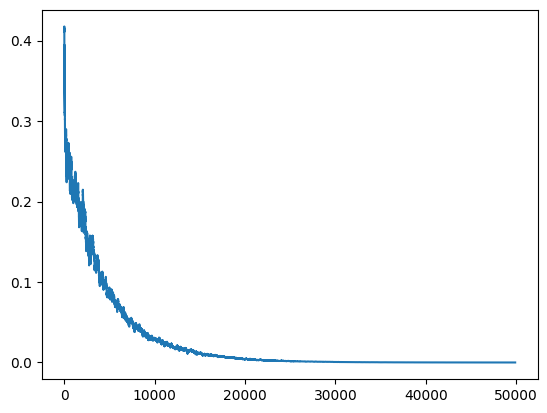

In [52]:
import matplotlib.pyplot as plt

plt.plot( list_of_avg_errors )
plt.show()

## Test the Perceptron

In [53]:
p( torch.tensor( [0.5, 0.5] ) )

tensor([1.4454e-06], grad_fn=<AddBackward0>)

In [54]:
p( torch.tensor( [0.3, 0.2] ) )

tensor([0.1000], grad_fn=<AddBackward0>)

In [55]:
p( torch.tensor( [0.2, 0.3] ) )

tensor([-0.1000], grad_fn=<AddBackward0>)

In [56]:
p( torch.tensor( [1.0, 1.0] ) )

tensor([-3.6269e-05], grad_fn=<AddBackward0>)